In [10]:
%pip install datasets

  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/60/2d/963b266bb8f88492d5ab4232d74292af8beb5b6fdae97902df9e284d4c32/datasets-2.20.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow>=15.0.0 from https://files.pythonhosted.org/packages/fa/15/48a68b30542a0231a75c26d8661bc5c9bbc07b42c5b219e929adba814ba7/pyarrow-16.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for pyarrow-hotfix from https://files.pythonhosted.org/packages/e4/f4/9ec2222f5f5f8ea04f66f184caafd991a39c8782e31f5b0266f101cb68ca/pyarrow_hotfix-0.6-py3-none-any.whl.metadata
  Obtaining dependency information for dill<0.3.9,>=0.3.0 from https://files.pythonhosted.org/packages/c9/7a/cef76fd8438a42f96db64ddaa85280485a9c395e7df3db8158cfec1eee34/dill-0.3.8-py3-none-any.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/fc/a5/4d82be566f069d7a9a702dcdf6f9106df0e0b042e738043c0cc7dd

In [30]:
from huggingface_hub import notebook_login
 
notebook_login()

In [4]:
processor_id="microsoft/layoutlmv2-base-uncased"
dataset_id ="nielsr/funsd"

In [5]:
from datasets import load_dataset
 
 
dataset = load_dataset(dataset_id)
 
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")
# Train dataset size: 149
# Test dataset size: 50

Train dataset size: 149
Test dataset size: 50


In [1]:
pip install pytesseract


  Obtaining dependency information for pytesseract from https://files.pythonhosted.org/packages/c5/54/ec007336f38d2d4ce61f3544af3e6855dacbf04a1ac8294f10cabe81146f/pytesseract-0.3.10-py3-none-any.whl.metadata
  Obtaining dependency information for Pillow>=8.0.0 from https://files.pythonhosted.org/packages/81/ff/ad3c942d865f9e45ce84eeb31795e6d4d94e1f1eea51026d5154028510d7/pillow-10.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from transformers import LayoutLMv2Processor
 
# use LayoutLMv2 processor without ocr since the dataset already includes the ocr text
processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)

2024-06-27 06:34:17.805786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 06:34:17.805840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 06:34:17.805863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 06:34:17.812984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")
 
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
#     Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
print(id2label, label2id)

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'} {'O': 0, 'B-HEADER': 1, 'I-HEADER': 2, 'B-QUESTION': 3, 'I-QUESTION': 4, 'B-ANSWER': 5, 'I-ANSWER': 6}


In [25]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D
 
print(dataset["train"].features.keys())

# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

only_one = True

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    global only_one

    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )

    if only_one:
        print("-----> ", encoding.keys())
        only_one = False
    del encoding["image"]
    return encoding
 
 
# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")
 
print(proc_dataset["train"].features.keys())
print(dataset["train"].features.keys())

# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])
 

dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image_path'])


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

----->  dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])
dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])
dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image_path'])


In [26]:
print(proc_dataset["train"].features)
#print(proc_dataset["train"][1])

{'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None), 'labels': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None)}


In [9]:
print(dataset["train"].features.keys())



dict_keys(['id', 'words', 'bboxes', 'ner_tags', 'image_path'])


In [21]:
from transformers import LayoutLMForTokenClassification
 
# huggingface hub model id
model_id = "microsoft/layoutlm-base-uncased"
 
# load model with correct number of labels and mapping
model = LayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
%pip install evaluate
%pip install seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for scikit-learn>=0.21.3 from https://files.pythonhosted.org/packages/46/c0/63d3a8da39a2ee051df229111aa93f6dca2b56f8080abd34993938166455/scikit_learn-1.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/89/bb/80c9c98d887c855710fd31fc5ae5574133e98203b3475b07579251803662/scipy-1.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.4 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted

In [26]:
import evaluate
import numpy as np
 
# load seqeval metric
metric = evaluate.load("seqeval")
 
# labels of the model
ner_labels = list(model.config.id2label.values())
 
 
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
 
    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])
 

In [28]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments
 
# hugging face parameter
repository_id = "layoutlm-funsd"
 
# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    fp16=True,
    learning_rate=3e-5,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)
 
# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Answer,Header,Question,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,1.781400,1.591901,"{'precision': 0.015602836879432624, 'recall': 0.013597033374536464, 'f1': 0.01453104359313078, 'number': 809}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}","{'precision': 0.14666666666666667, 'recall': 0.09295774647887324, 'f1': 0.11379310344827587, 'number': 1065}",0.079710,0.055193,0.065224,0.350222
2,1.446000,1.248202,"{'precision': 0.15749235474006115, 'recall': 0.1273176761433869, 'f1': 0.14080656185919346, 'number': 809}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}","{'precision': 0.45069393718042366, 'recall': 0.5793427230046948, 'f1': 0.5069843878389482, 'number': 1065}",0.355907,0.361264,0.358566,0.591875
3,1.095500,0.965328,"{'precision': 0.44740024183796856, 'recall': 0.4573547589616811, 'f1': 0.45232273838630804, 'number': 809}","{'precision': 0.030303030303030304, 'recall': 0.008403361344537815, 'f1': 0.013157894736842105, 'number': 119}","{'precision': 0.5621703089675961, 'recall': 0.7004694835680751, 'f1': 0.6237458193979933, 'number': 1065}",0.510745,0.560462,0.534450,0.700444
4,0.841300,0.806331,"{'precision': 0.6070686070686071, 'recall': 0.7218788627935723, 'f1': 0.6595143986448335, 'number': 809}","{'precision': 0.1111111111111111, 'recall': 0.05042016806722689, 'f1': 0.06936416184971099, 'number': 119}","{'precision': 0.6669527896995708, 'recall': 0.7295774647887324, 'f1': 0.6968609865470853, 'number': 1065}",0.626777,0.685901,0.655007,0.749475
5,0.670800,0.712326,"{'precision': 0.6703539823008849, 'recall': 0.7490729295426453, 'f1': 0.7075306479859895, 'number': 809}","{'precision': 0.11458333333333333, 'recall': 0.09243697478991597, 'f1': 0.10232558139534885, 'number': 119}","{'precision': 0.6787401574803149, 'recall': 0.8093896713615023, 'f1': 0.7383297644539615, 'number': 1065}",0.651542,0.742097,0.693878,0.784147
6,0.566000,0.700537,"{'precision': 0.6466466466466466, 'recall': 0.7985166872682324, 'f1': 0.7146017699115044, 'number': 809}","{'precision': 0.13725490196078433, 'recall': 0.11764705882352941, 'f1': 0.12669683257918554, 'number': 119}","{'precision': 0.7279151943462897, 'recall': 0.7737089201877935, 'f1': 0.7501137915339099, 'number': 1065}",0.664577,0.744606,0.702319,0.782629
7,0.496900,0.676364,"{'precision': 0.6817691477885652, 'recall': 0.7812113720642769, 'f1': 0.7281105990783411, 'number': 809}","{'precision': 0.21666666666666667, 'recall': 0.2184873949579832, 'f1': 0.21757322175732216, 'number': 119}","{'precision': 0.7367521367521368, 'recall': 0.8093896713615023, 'f1': 0.7713646532438478, 'number': 1065}",0.685611,0.762669,0.722090,0.795004
8,0.429500,0.673506,"{'precision': 0.7071823204419889, 'recall': 0.7911001236093943, 'f1': 0.7467911318553092, 'number': 809}","{'precision': 0.21311475409836064, 'recall': 0.2184873949579832, 'f1': 0.21576763485477177, 'number': 119}","{'precision': 0.7489397794741306, 'recall': 0.8291079812206573, 'f1': 0.78698752228164, 'number': 1065}",0.702176,0.777220,0.737795,0.799206
9,0.377400,0.681378,"{'precision': 0.7023809523809523, 'recall': 0.8022249690976514, 'f1': 0.7489901904212348, 'number': 809}","{'precision': 0.2773109243697479, 'recall': 0.2773109243697479, 'f1': 0.2773109243697479, 'number': 119}","{'precision': 0.7639372822299652, 'recall': 0.8234741784037559, 'f1': 0.7925892453682785, 'number': 1065}",0.711547,0.782238,0.745220,0.804693
10,0.367800,0.688454,"{'precision': 0.7193370165745856, 'recall': 0.8046971569839307, 'f1': 0.7596266044340723, 'number': 809}","{'precision': 0.264, 'recall': 0.2773109243697479, 'f1': 0.27049180327868855, 'number': 119}","{'precision': 0.7690972222222222, 'recall': 0.831924882629108, 'f1': 0.799278304014434, 'number': 1065}",0.719523,0.787757,0.752096,0.805043


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.015602836879432624, 'recall': 0.013597033374536464, 'f1': 0.01453104359313078, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.14666666666666667, 'recall': 0.09295774647887324, 'f1': 0.11379310344827587, 'number

TrainOutput(global_step=150, training_loss=0.6328805748621623, metrics={'train_runtime': 1419.1304, 'train_samples_per_second': 1.575, 'train_steps_per_second': 0.106, 'total_flos': 588079608192000.0, 'train_loss': 0.6328805748621623, 'epoch': 15.0})

In [31]:
# change apply_ocr to True to use the ocr text for inference
processor.feature_extractor.apply_ocr = True
 
# Save processor and create model card
processor.save_pretrained(repository_id)
trainer.create_model_card()
trainer.push_to_hub()

/usr/local/lib/python3.11/dist-packages/transformers/models/layoutlmv2/processing_layoutlmv2.py:197: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


events.out.tfevents.1719332002.6e4639ec1be2.39.0:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/blaackjack/layoutlm-funsd/commit/6b0009a95e72afd658839185004bef65c9b2606e', commit_message='End of training', commit_description='', oid='6b0009a95e72afd658839185004bef65c9b2606e', pr_url=None, pr_revision=None, pr_num=None)

In [15]:
import pytesseract

# Spécifiez manuellement le chemin de l'exécutable Tesseract si nécessaire
#pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# Votre code qui utilise pytesseract


from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
from PIL import Image, ImageDraw, ImageFont
import torch
 
# load model and processor from huggingface hub
#model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd")
#processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd")
 
 
# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]
 
 
label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    #rint('image_size ', width, height)
    #print('unormalized? ', boxes)
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]
    #print('normalizzed? ', normalizes_boxes)
    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
     #   draw.rectangle(box, outline=label2color[prediction])
        draw.rectangle(box, outline="red")
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill="red", font=font)
    return image
 
 
# run inference
def run_inference(path, model=model, processor=processor, output_image=True):
    # create model input
    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="pt")
    del encoding["image"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels
 
 
#run_inference(dataset["test"][25]["image_path"])


[[113, 212, 178, 230], [113, 243, 191, 263], [110, 275, 208, 295], [113, 307, 208, 325], [110, 339, 184, 357], [211, 282, 322, 296], [122, 89, 228, 106], [228, 88, 317, 108], [187, 105, 256, 122], [131, 120, 262, 140], [261, 123, 284, 140], [284, 123, 312, 140], [383, 64, 425, 79], [431, 64, 517, 81], [527, 66, 638, 86], [434, 98, 494, 113], [504, 99, 578, 114], [344, 126, 436, 141], [479, 130, 566, 144], [572, 133, 685, 148], [401, 159, 552, 176], [564, 163, 609, 178], [708, 103, 803, 123], [816, 106, 877, 123], [898, 110, 951, 125], [214, 218, 288, 235], [292, 218, 321, 235], [332, 219, 418, 236], [211, 250, 273, 265], [280, 251, 368, 266], [211, 314, 258, 329], [257, 314, 322, 329], [328, 317, 412, 334], [422, 318, 462, 333], [470, 321, 529, 336], [539, 321, 570, 335], [594, 320, 652, 337], [211, 339, 270, 357], [280, 338, 327, 355], [330, 339, 379, 357], [106, 404, 175, 421], [179, 404, 230, 419], [297, 406, 374, 426], [390, 408, 475, 426], [481, 412, 503, 427], [507, 415, 557, 430

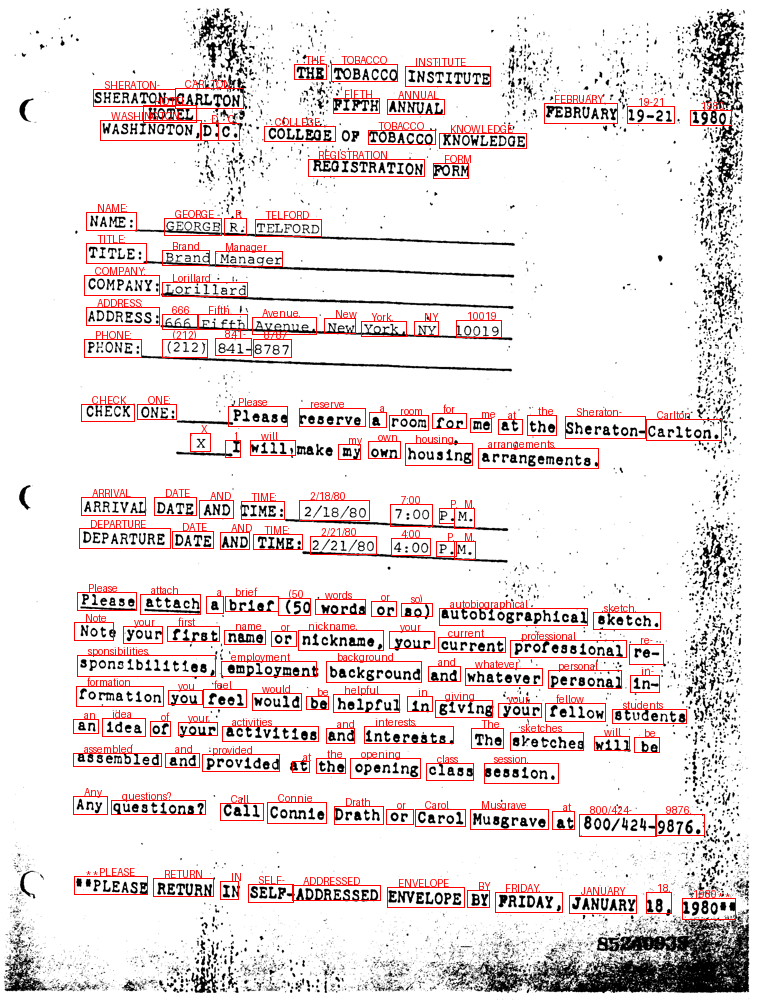

In [20]:
data = dataset["test"][25]
#print(data)
image_test= Image.open(data["image_path"]).convert("RGB")
print(data["bboxes"])
draw_boxes(image_test, data["bboxes"],  data["words"])


shuffled
angle -4.74989244777333


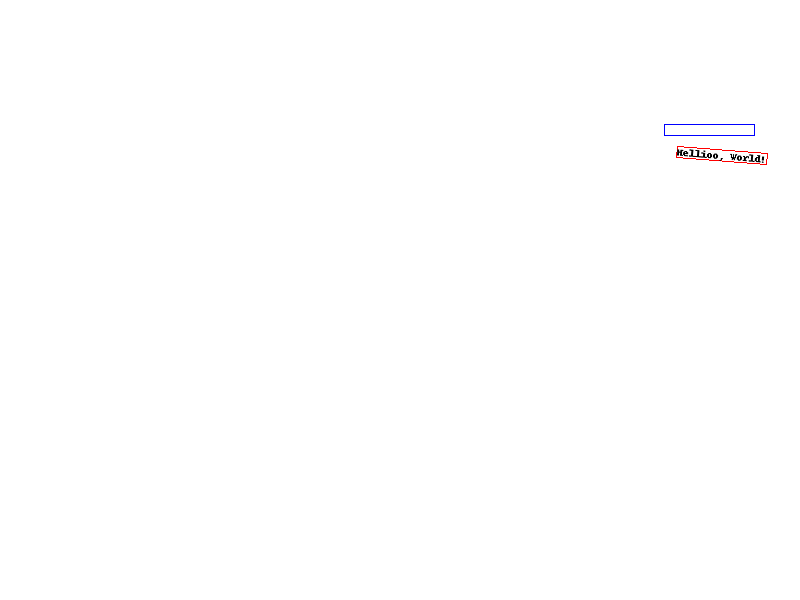

shuffled
angle 1.9622432263705285


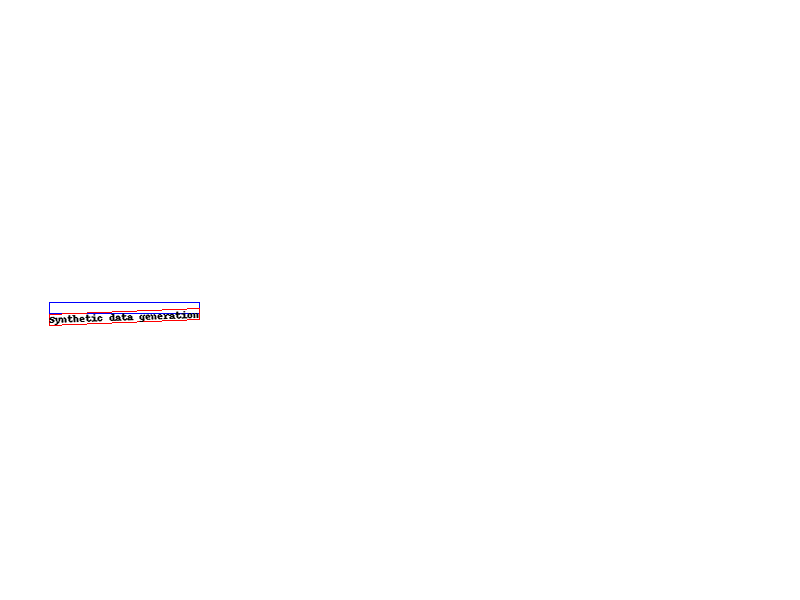

In [55]:
import math
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np

call_count = 0

def generate_synthetic_image(text, width=800, height=600, seed=0):
    global call_count
    if seed is not None:
        random.seed(seed + call_count)
        np.random.seed(seed + call_count)
        call_count += 1
        print("shuffled")
    # en vrai, il faudrait même throw une erreur si le seed est pas initilisé.
    
    # Créer une nouvelle image
    image = Image.new("RGB", (width, height), color=(255, 255, 255))
    draw = ImageDraw.Draw(image)
    
    # Charger la police
    font = ImageFont.load_default()
    
    # Déterminer la taille du texte pour le positionnement
    text_size = draw.textbbox((0, 0), text, font=font)
    text_width = text_size[2] - text_size[0]
    text_height = text_size[3] - text_size[1]
    
    # Position aléatoire mais garantir que le texte reste dans l'image
    x = random.randint(10, width - text_width - 10)
    y = random.randint(10, height - text_height - 10) # * hauteurs de ttes les lignes
    
    # Rotation aléatoire
    angle = random.uniform(-5, 5)
    print("angle", angle)
    
    # Créer une image temporaire pour la rotation
    temp_image = Image.new("RGBA", (width, height), (255, 255, 255, 0))
    temp_draw = ImageDraw.Draw(temp_image)
    temp_draw.text((x, y), text, font=font, fill=(0, 0, 0))
    
    # Calculer les coordonnées des coins de la bbox
    corners = [
        (x, y),
        (x + text_width, y),
        (x + text_width, y + text_height),
        (x, y + text_height)
    ]
    
    # Fonction pour faire pivoter un point
    def rotate_point(point, center, angle):
        angle_rad = math.radians(angle)
        px, py = point
        cx, cy = center
        s, c = math.sin(angle_rad), math.cos(angle_rad)
        px, py = px - cx, py - cy
        return (
            cx + (px * c + py * s),
            cy + (-px * s + py * c)
        )
    
    # Centre de rotation (centre de l'image)
    center = (width / 2, height / 2)
    
    # Faire pivoter chaque coin autour du centre de l'image
    rotated_corners = [rotate_point(corner, center, angle) for corner in corners]
    
    # Rotation de l'image temporaire
    rotated_temp_image = temp_image.rotate(angle, resample=Image.BICUBIC, expand=0, center=center)
    
    # Dessiner le polygone sur l'image principale
    draw.polygon(corners, outline="blue")

    draw.polygon(rotated_corners, outline="red")
    
    # Composer l'image finale
    image = Image.alpha_composite(image.convert("RGBA"), rotated_temp_image).convert("RGB")
    
    return image

# Test de la fonction
seed = 42
texts = ["Hellioo, World!", "Synthetic data generation"]
for i, text in enumerate(texts):
    img = generate_synthetic_image(text, width=800, height=600, seed=42)
    img.save(f"synthetic_image_{i}.png")
    img.show()

ADIPISCI TEMPORA EST EIUS.
-->  (0, 0, 156, 11)
AMET QUAERAT MODI ALIQUAM ADIPISCI AMET DOLOREM EIUS.
QUIQUIA ADIPISCI PORRO DOLOREM SIT QUISQUAM SIT PORRO.
EIUS NEQUE QUAERAT EST VELIT ADIPISCI UT.
SIT MODI IPSUM EST DOLOR.
UT IPSUM CONSECTETUR AMET MAGNAM.
LABORE LABORE QUIQUIA EST.
TEMPORA NEQUE PORRO CONSECTETUR.
AMET PORRO ETINCIDUNT VOLUPTATEM QUISQUAM QUIQUIA LABORE.
DOLOREM SIT AMET ALIQUAM SED EIUS UT ETINCIDUNT.
EIUS CONSECTETUR MAGNAM EST.
QUISQUAM VOLUPTATEM LABORE DOLORE LABORE LABORE DOLOREM.
SIT SED QUISQUAM AMET QUIQUIA QUISQUAM.
PORRO TEMPORA EIUS DOLORE NEQUE.
EST QUISQUAM SIT PORRO EIUS SED IPSUM.
EIUS VOLUPTATEM ALIQUAM VELIT.


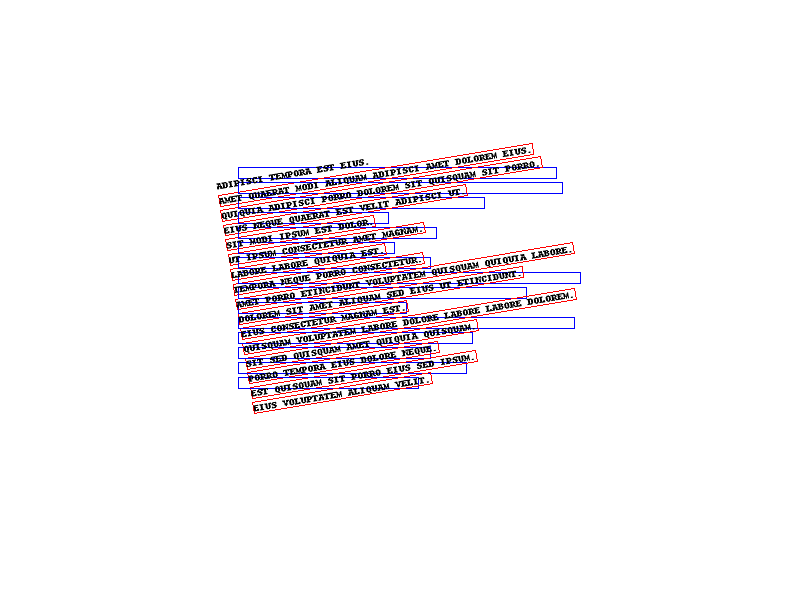

ETINCIDUNT SIT UT DOLOR.
-->  (0, 0, 144, 11)
NEQUE QUIQUIA NON QUIQUIA.
NUMQUAM MODI QUAERAT LABORE.
PORRO UT MODI MAGNAM DOLORE ALIQUAM CONSECTETUR VOLUPTATEM.
MAGNAM DOLOR CONSECTETUR DOLORE.
VOLUPTATEM NON DOLOR UT MAGNAM QUIQUIA NUMQUAM EST.
DOLORE MAGNAM AMET ALIQUAM QUAERAT ALIQUAM DOLORE ALIQUAM.
ETINCIDUNT EST AMET NUMQUAM QUIQUIA.
VOLUPTATEM QUAERAT QUISQUAM QUISQUAM.
CONSECTETUR QUIQUIA NEQUE VELIT.
IPSUM NUMQUAM SED SIT NEQUE DOLORE.
AMET UT IPSUM ALIQUAM QUAERAT.
LABORE TEMPORA DOLORE SED QUIQUIA AMET.
SED CONSECTETUR ETINCIDUNT NON UT TEMPORA LABORE SIT.
ALIQUAM NON MODI QUIQUIA UT AMET LABORE.
QUISQUAM AMET SED TEMPORA DOLOR.


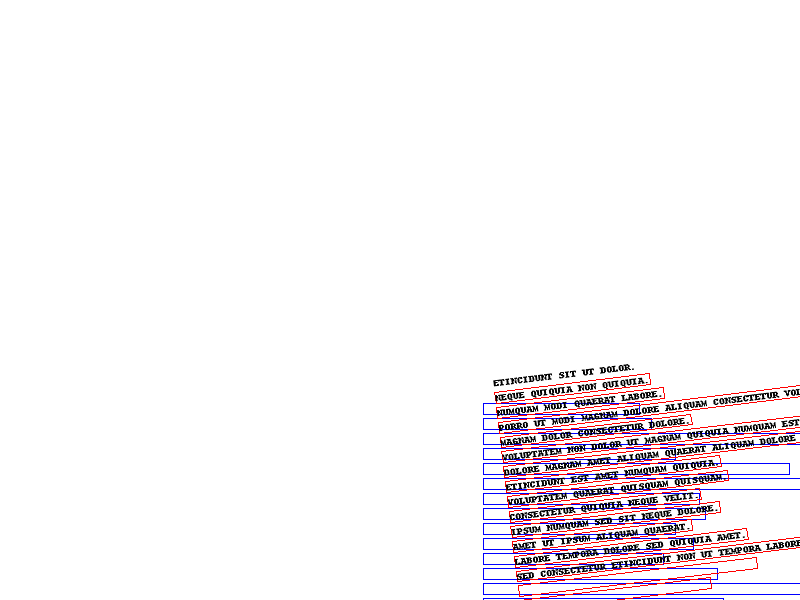

NUMQUAM PORRO SIT CONSECTETUR DOLORE MAGNAM EIUS.
-->  (0, 0, 294, 11)
ADIPISCI CONSECTETUR DOLORE UT NUMQUAM SIT ETINCIDUNT SIT.
QUAERAT MAGNAM UT SIT SED IPSUM LABORE.
IPSUM VOLUPTATEM ETINCIDUNT QUIQUIA.
CONSECTETUR NUMQUAM AMET QUAERAT CONSECTETUR.
IPSUM CONSECTETUR QUISQUAM VOLUPTATEM ETINCIDUNT ALIQUAM.
MAGNAM CONSECTETUR NON NON DOLOREM DOLOREM.
EST TEMPORA EIUS UT ALIQUAM.
SED VOLUPTATEM SED MODI.
TEMPORA SIT SIT TEMPORA.
LABORE VOLUPTATEM NON QUISQUAM NEQUE QUAERAT.
DOLOR EIUS NON NEQUE VELIT TEMPORA SED LABORE.
VOLUPTATEM VOLUPTATEM TEMPORA ALIQUAM EST DOLORE ADIPISCI EIUS.
QUAERAT UT QUIQUIA QUISQUAM.
PORRO ETINCIDUNT LABORE QUAERAT DOLOREM MAGNAM CONSECTETUR LABORE.
CONSECTETUR VOLUPTATEM EIUS QUIQUIA SIT ALIQUAM.


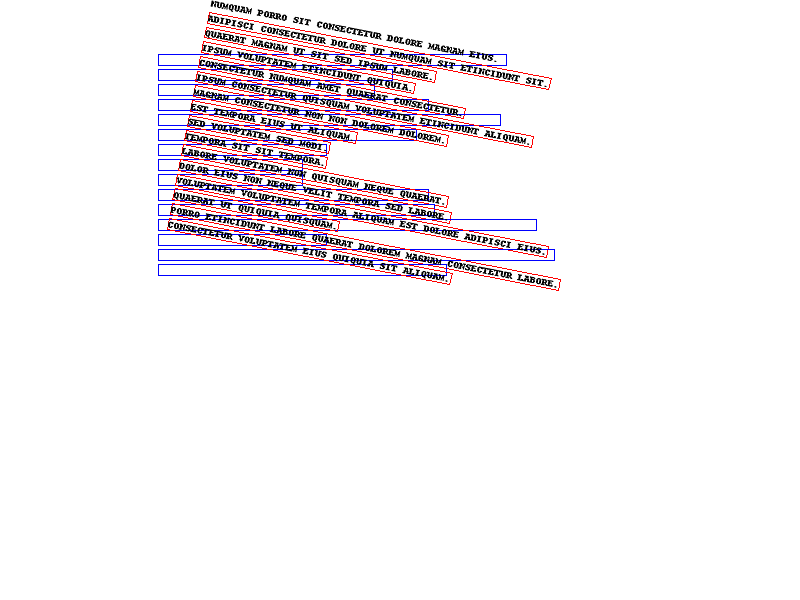

In [58]:
import math
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
import lorem

import glob
import os

def apply_text_effects(text):
    # Appliquer des effets aléatoires au texte
    if random.choice([True, False]):
        text = text.upper()  # Majuscules
        print('a')
    if random.choice([True, False]):
        text = text.capitalize()  # Capitaliser
        print('b')      
    return text
    
# keep randomness predictible
call_count = 0


def generate_synthetic_image(bloc_lines=10, width=800, height=600, padding_bloc=15, seed=0):
    global call_count
    if seed is not None:
        random.seed(seed + call_count)
        np.random.seed(seed + call_count)
        call_count += 1
    # en vrai, il faudrait même throw une erreur si le seed est pas initilisé.
    
    # utils pour faire pivoter un point
    def rotate_point(point, center, angle):
        angle_rad = math.radians(angle)
        px, py = point
        cx, cy = center
        s, c = math.sin(angle_rad), math.cos(angle_rad)
        px, py = px - cx, py - cy
        return (
            cx + (px * c + py * s),
            cy + (-px * s + py * c)
        )
    
    # Créer une nouvelle image
    image = Image.new("RGB", (width, height), color=(255, 255, 255))
    draw = ImageDraw.Draw(image)

      # Créer une image temporaire pour la rotation
    temp_image = Image.new("RGBA", (width, height), (255, 255, 255, 0))
    temp_draw = ImageDraw.Draw(temp_image)

    # Charger la police
    font = ImageFont.load_default()
    
    # Déterminer la taille du texte pour le positionnement
    text = lorem.sentence().upper() # repeat !!!!
   # text = apply_text_effects(text)
    print(text)
    text_size = draw.textbbox((0, 0), text, font=font)
    print("--> ", text_size) 
    text_width = text_size[2] - text_size[0]
    text_height = text_size[3] - text_size[1]
    
    # Position aléatoire mais garantir que le texte reste dans l'image
    x = random.randint(10, width - text_width - 10)
    y = random.randint(10, height - text_height - 10) # * hauteurs de ttes les lignes ---------

    angle = random.uniform(-20, 20)

    temp_draw.text((x, y), text, font=font, fill=(0, 0, 0))

    # Rotation aléatoire
    for i in  range(bloc_lines):
    
        y += padding_bloc
        text = lorem.sentence().upper()# repeat !!!!
        print(text)
        text_size = draw.textbbox((0, 0), text, font=font)
        text_width = text_size[2] - text_size[0]
        text_height = text_size[3] - text_size[1]
    
        temp_draw.text((x, y), text, font=font, fill=(0, 0, 0))

        # faire fonction helper
        # Calculer les coordonnées des coins de la bbox
        corners = [
            (x, y),
            (x + text_width, y),
            (x + text_width, y + text_height),
            (x, y + text_height)
        ]
    
        # Centre de rotation (centre de l'image)
        center = (width / 2, height / 2)
    
        # Faire pivoter chaque coin autour du centre de l'image
        rotated_corners = [rotate_point(corner, center, angle) for corner in corners]
    
        # Rotation de l'image temporaire
        rotated_temp_image = temp_image.rotate(angle, resample=Image.BICUBIC, expand=0, center=center)
    
        # Dessiner le polygone sur l'image principale
        draw.polygon(corners, outline="blue")
        draw.polygon(rotated_corners, outline="red")
    
        # Composer l'image finale
    image = Image.alpha_composite(image.convert("RGBA"), rotated_temp_image).convert("RGB")
    
    return image

# Test de la fonction
seed = 42
for i in range(3):
    img = generate_synthetic_image(bloc_lines=15, width=800, height=600, padding_bloc=15, seed=42)
   # img.save(f"synthetic_image_{i}.png")
    img.show()

Ajusté à 38 lignes pour s'adapter à la hauteur de l'image


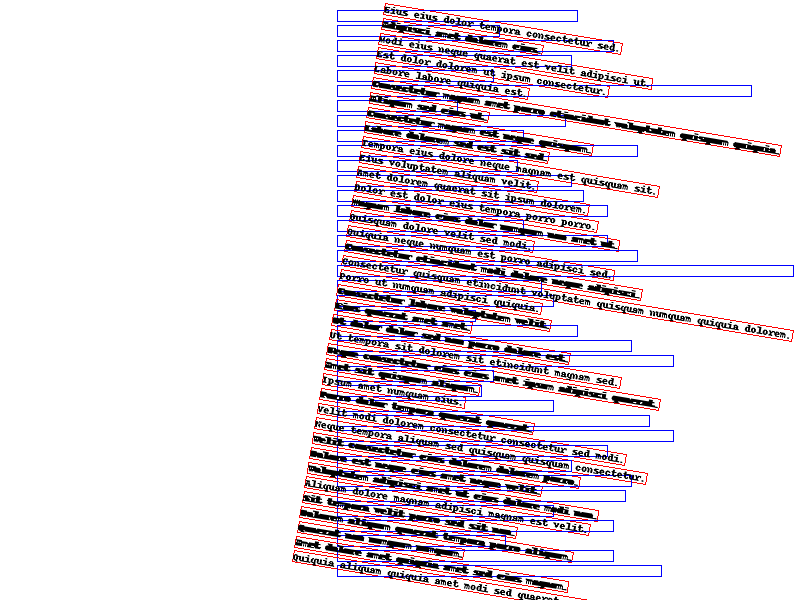

Ajusté à 38 lignes pour s'adapter à la hauteur de l'image


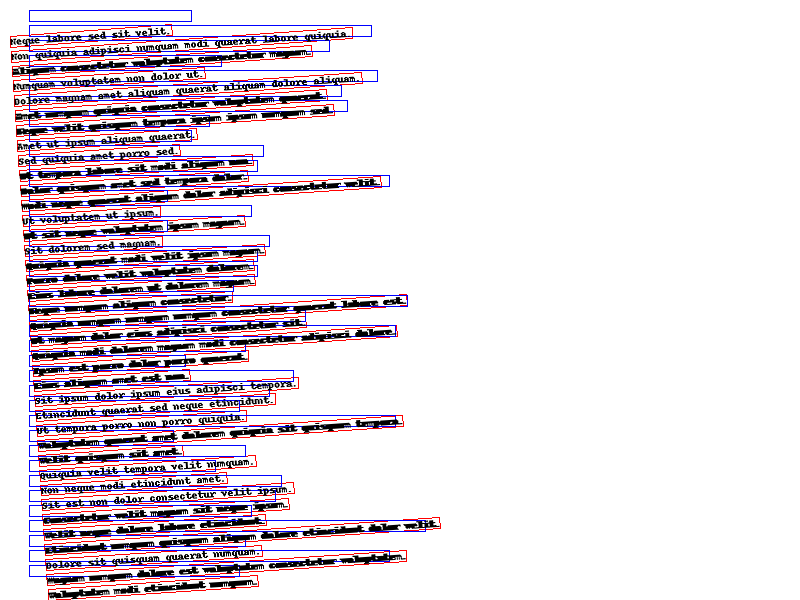

Ajusté à 38 lignes pour s'adapter à la hauteur de l'image


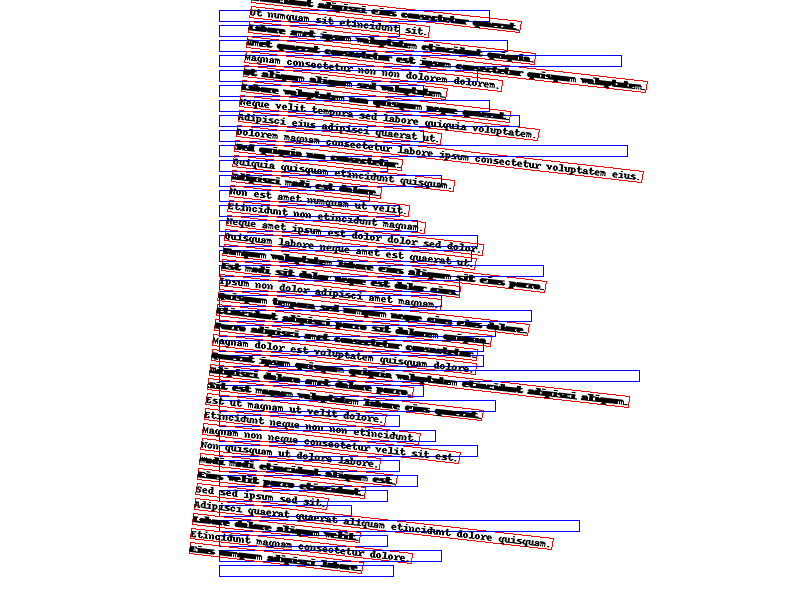

In [73]:
import random
import math
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import lorem

call_count = 0

def draw_text(draw, position, text, font, bold=False, italic=False):
    # Dessiner le texte avec des effets
    if bold:
        draw.text(position, text, font=font, fill=(0, 0, 0), stroke_width=2, stroke_fill=(0, 0, 0))
    else:
        draw.text(position, text, font=font, fill=(0, 0, 0))

    if italic:
        draw.text((position[0] + 2, position[1]), text, font=font, fill=(0, 0, 0))

def generate_synthetic_image(bloc_lines=10, width=800, height=600, padding_bloc=15, seed=0):
    global call_count
    if seed is None:
        raise ValueError("Seed must be initialized")
    
    random.seed(seed + call_count)
    np.random.seed(seed + call_count)
    call_count += 1

    image = Image.new("RGB", (width, height), color=(255, 255, 255))
    draw = ImageDraw.Draw(image)
    temp_image = Image.new("RGBA", (width, height), (255, 255, 255, 0))
    temp_draw = ImageDraw.Draw(temp_image)
    font = ImageFont.load_default()

    def draw_text_and_bbox(x, y, text):
       # temp_draw.text((x, y), text, font=font, fill=(0, 0, 0))
        is_bold = random.choice([True, False])
        is_italic = random.choice([True, False])
        
        draw_text(temp_draw, (x, y), text, font=font, bold=is_bold, italic=is_italic)
        text_size = draw.textbbox((0, 0), text, font=font)
        text_width = text_size[2] - text_size[0]
        text_height = text_size[3] - text_size[1]

        corners = [
            (x, y),
            (x + text_width, y),
            (x + text_width, y + text_height),
            (x, y + text_height)
        ]

        rotated_corners = [rotate_point(corner, (width/2, height/2), angle) for corner in corners]
        draw.polygon(rotated_corners, outline="red")
        draw.polygon(corners, outline="blue")

    def rotate_point(point, center, angle):
        angle_rad = math.radians(angle)
        px, py = point
        cx, cy = center
        s, c = math.sin(angle_rad), math.cos(angle_rad)
        px, py = px - cx, py - cy
        return (
            cx + (px * c + py * s),
            cy + (-px * s + py * c)
        )

      # Calculer la hauteur approximative nécessaire pour le bloc de texte
    line_height = font.getbbox('A')[1]
    total_height = bloc_lines * (line_height + padding_bloc)
    
    # Ajuster le nombre de lignes si nécessaire
    if total_height > height - 20:  # 20 pixels de marge
        bloc_lines = (height - 20) // (line_height + padding_bloc)
        print(f"Ajusté à {bloc_lines} lignes pour s'adapter à la hauteur de l'image")
    
    # Calculer les positions x et y initiales
    max_text_width = 300  # Estimation de la largeur maximale du texte
    x = random.randint(10, max(10, width - max_text_width - 10))
    y = random.randint(10, max(10, height - total_height - 10))
      
    angle = random.uniform(-10, 10)

    for i in range(bloc_lines):
       # text = lorem.sentence().upper()
        text = lorem.sentence()

        draw_text_and_bbox(x, y, text)
        y += padding_bloc

    rotated_temp_image = temp_image.rotate(angle, resample=Image.BICUBIC, expand=0, center=(width/2, height/2))
    image = Image.alpha_composite(image.convert("RGBA"), rotated_temp_image).convert("RGB")

    return image

# Usage
seed = 42
for i in range(3):
    img = generate_synthetic_image(bloc_lines=50, seed=seed)
    #img.save("synthetic_block_text.png")
    img.show()

words:  0  ->  Tempora est eius eius.
bbox x1, y1, x2, Y2 =  0  ->  0.0 , 0.0 , 132.0 , 11.0
json:  {'id': 0, 'words': ['Tempora est eius eius.'], 'bboxes': [[0.0, 0.0, 132.0, 11.0]], 'ner_tags': [1], 'image_path': 'synth_layout/synth_0.png'}


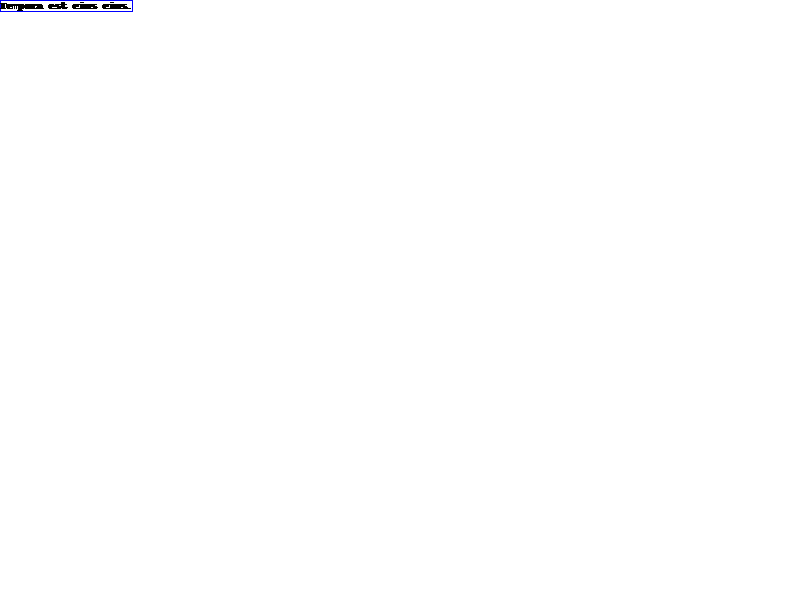

In [60]:
import random
import math
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import lorem
from datasets import DatasetDict

call_count = 0

def draw_text(draw, position, text, font, bold=False, italic=False):
    # Dessiner le texte avec des effets
    if bold:
        draw.text(position, text, font=font, fill=(0, 0, 0), stroke_width=2, stroke_fill=(0, 0, 0))
    else:
        draw.text(position, text, font=font, fill=(0, 0, 0))

    if italic:
        draw.text((position[0] + 2, position[1]), text, font=font, fill=(0, 0, 0))

def generate_synthetic_image(save_path, bloc_lines=10, width=800, height=600, padding_bloc=15, seed=0):
    global call_count
    if seed is None:
        raise ValueError("Seed must be initialized")

    features = {'id': 0,
                'words': [],
                'bboxes': [],
                'ner_tags': [],
                'image_path': ""}
    
    random.seed(seed + call_count)
    np.random.seed(seed + call_count)
    call_count += 1

    image = Image.new("RGB", (width, height), color=(255, 255, 255))
    draw = ImageDraw.Draw(image)
    temp_image = Image.new("RGBA", (width, height), (255, 255, 255, 0))
    temp_draw = ImageDraw.Draw(temp_image)
    font = ImageFont.load_default()

    def draw_text_and_bbox(x, y, text, indice):
       # temp_draw.text((x, y), text, font=font, fill=(0, 0, 0))
        is_bold = random.choice([True, False])
        is_italic = random.choice([True, False])
        
        draw_text(temp_draw, (x, y), text, font=font, bold=is_bold, italic=is_italic)
        text_size = draw.textbbox((0, 0), text, font=font)
        text_width = text_size[2] - text_size[0]
        text_height = text_size[3] - text_size[1]

        corners = [
            (x, y),
            (x + text_width, y),
            (x + text_width, y + text_height),
            (x, y + text_height)
        ]

        rotated_corners = [rotate_point(corner, (width/2, height/2), angle) for corner in corners]
        draw.polygon(rotated_corners, outline="red")
       # print("-->", rotated_corners)
        print("bbox x1, y1, x2, Y2 = ", i, " -> ", rotated_corners[0][0], ",", rotated_corners[0][1], ",",
              rotated_corners[2][0], ",", rotated_corners[2][1])
        #convert to 2 points: x1, y1, x2, y2. Same index as words
        features['bboxes'].append([rotated_corners[0][0], rotated_corners[0][1], 
                                    rotated_corners[2][0], rotated_corners[2][1]])
        # will be enum of style. Here 1 for 'line' type. Let's hope it works.
        features['ner_tags'].append(1)
        
        draw.polygon(corners, outline="blue")

    def rotate_point(point, center, angle):
        angle_rad = math.radians(angle)
        px, py = point
        cx, cy = center
        s, c = math.sin(angle_rad), math.cos(angle_rad)
        px, py = px - cx, py - cy
        return (
            cx + (px * c + py * s),
            cy + (-px * s + py * c)
        )

      # Calculer la hauteur approximative nécessaire pour le bloc de texte
    line_height = font.getbbox('A')[1]
    total_height = bloc_lines * (line_height + padding_bloc)
    
    # Ajuster le nombre de lignes si nécessaire
    if total_height > height - 20:  # 20 pixels de marge
        bloc_lines = (height - 20) // (line_height + padding_bloc)
        print(f"Ajusté à {bloc_lines} lignes pour s'adapter à la hauteur de l'image")
    
    # Calculer les positions x et y initiales
    max_text_width = 300  # Estimation de la largeur maximale du texte
    x = random.randint(10, max(10, width - max_text_width - 10))
    y = random.randint(10, max(10, height - total_height - 10))
    x = 0
    y = 0
    #angle = random.uniform(-10, 10)
    angle = 0

    for i in range(bloc_lines):
       # text = lorem.sentence().upper()
        text = lorem.sentence()
        print("words: ", i, " -> ", text)
        features['words'].append(text)
        draw_text_and_bbox(x, y, text, i)
        y += padding_bloc

    rotated_temp_image = temp_image.rotate(angle, resample=Image.BICUBIC, expand=0, center=(width/2, height/2))
    image = Image.alpha_composite(image.convert("RGBA"), rotated_temp_image).convert("RGB")
    
    # faire un check du save
    image.save(save_path)
    features["image_path"] = save_path
    return image, features

# Usage
seed = 42
list_features = []

for i in range(1):
    file_path = f"synth_layout/synth_{i}.png"
    img, image_feature = generate_synthetic_image(save_path=file_path, bloc_lines=1, seed=seed)
    #list_features.append(image_feature)
    #img.save("synthetic_block_text.png")
    print("json: ", image_feature)
    list_features.append(image_feature)
    img.show()

dataset_dict = DatasetDict({
    "train": Dataset.from_list(list_features)
})


In [59]:
print("dataset_t: ", dataset_dict)
print("data_" , dataset)

dataset_t:  DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 1
    })
})
data_ DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 50
    })
})
